In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
import sys
sys.path.append('../src')

from data.data_loader import MovielensDataloader
from data.preprocessor import DataPreprocessor
from models.collaborative_filtering import CollaborativeFiltering, MemoryEfficientCF
from models.matrix_factorization import SVDRecommender, NMFRecommender, ALSRecommender, BiasedMF
from models.content_based import ContentBasedRecommender, TFIDFContentRecommender
from models.deep_learning import NeuralCollaborativeFiltering, AutoEncoder, WideAndDeep
from models.hybrid import WeightedHybrid, SwitchingHybrid, MixedHybrid, FeatureCombinationHybrid
from evaluation.metrics import RecommendationMetrics
from evaluation.evaluator import RecommendationEvaluator

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== Movie Recommendation System - MovieLens 100k ===")
print("Implementing various ML models for recommendation engines\n")

=== Movie Recommendation System - MovieLens 100k ===
Implementing various ML models for recommendation engines



In [2]:
print("1. Loading and Exploring Data")
print("-" * 50)

# Initialize data loader
loader = MovielensDataloader('../data/raw/ml-100k/')

# Load all datasets
ratings, movies, users = loader.load_all_data()

print(f"Dataset Statistics:")
print(f"- Users: {ratings['user_id'].nunique()}")
print(f"- Items: {ratings['item_id'].nunique()}")
print(f"- Ratings: {len(ratings)}")
print(f"- Density: {len(ratings) / (ratings['user_id'].nunique() * ratings['item_id'].nunique()) * 100:.2f}%")
print(f"- Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print()

1. Loading and Exploring Data
--------------------------------------------------
Dataset Statistics:
- Users: 943
- Items: 1682
- Ratings: 100000
- Density: 6.30%
- Rating range: 1 - 5



In [3]:
# Basic statistics
print("Rating Distribution:")
print(ratings['rating'].value_counts().sort_index())
print()

print("User Demographics:")
print(f"Age range: {users['age'].min()} - {users['age'].max()}")
print(f"Gender distribution: {users['gender'].value_counts()}")
print()


Rating Distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64

User Demographics:
Age range: 7 - 73
Gender distribution: gender
M    670
F    273
Name: count, dtype: int64



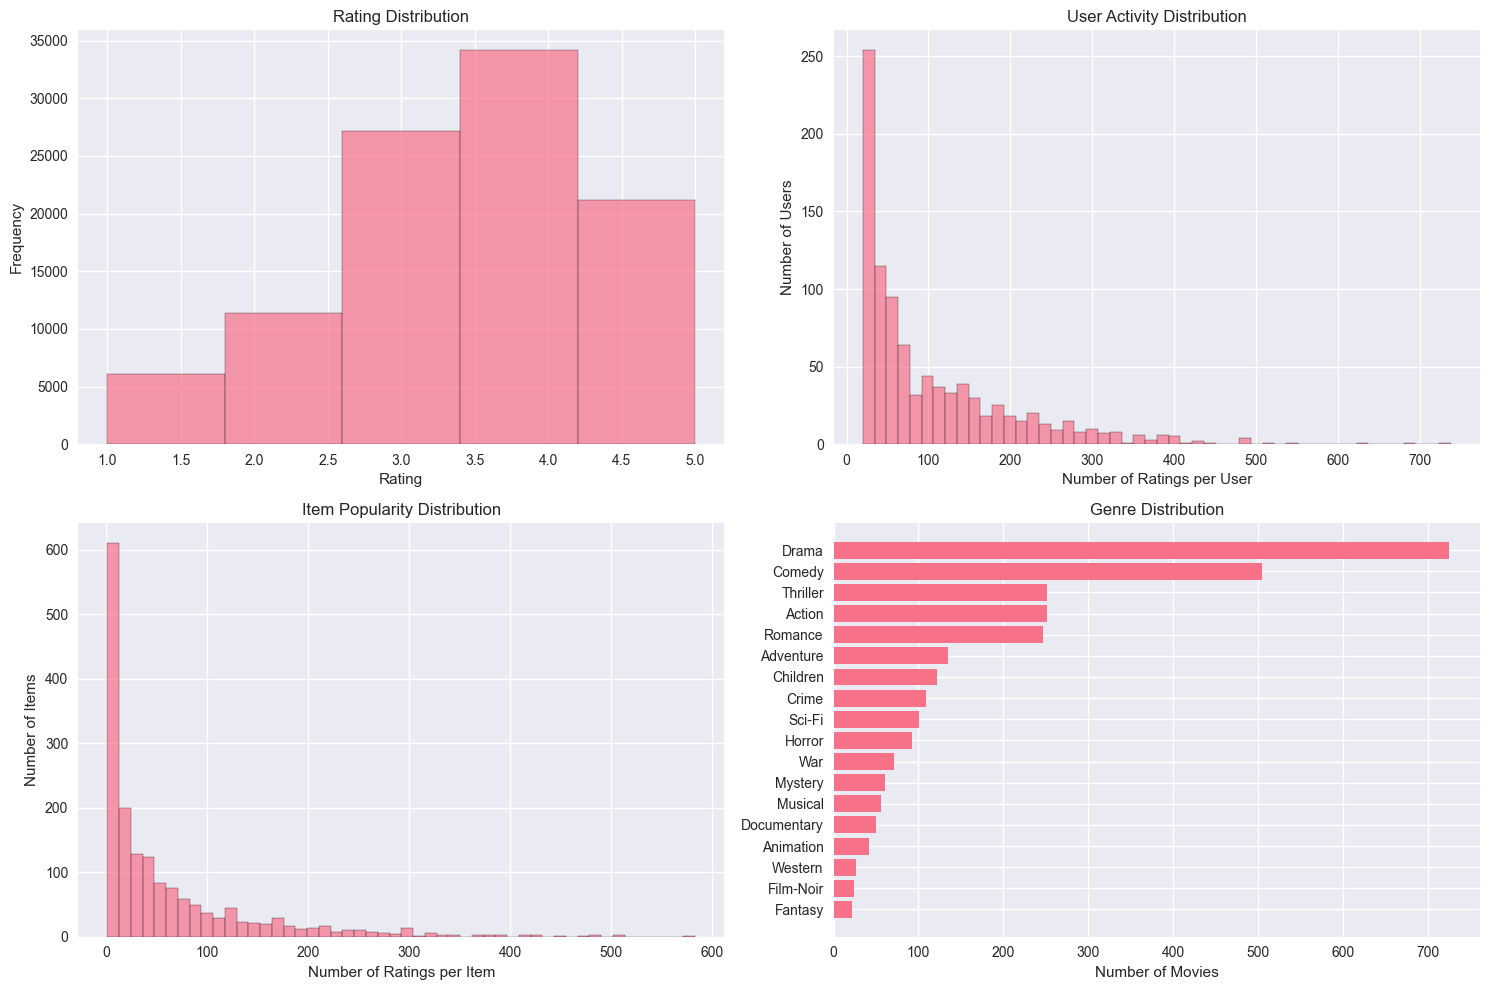

In [4]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].hist(ratings['rating'], bins=5, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')

# User activity distribution
user_activity = ratings.groupby('user_id').size()
axes[0, 1].hist(user_activity, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('User Activity Distribution')
axes[0, 1].set_xlabel('Number of Ratings per User')
axes[0, 1].set_ylabel('Number of Users')

# Item popularity distribution
item_popularity = ratings.groupby('item_id').size()
axes[1, 0].hist(item_popularity, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Item Popularity Distribution')
axes[1, 0].set_xlabel('Number of Ratings per Item')
axes[1, 0].set_ylabel('Number of Items')

# Genre distribution
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
             'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_counts = movies[genre_cols].sum().sort_values(ascending=True)
axes[1, 1].barh(range(len(genre_counts)), genre_counts.values)
axes[1, 1].set_yticks(range(len(genre_counts)))
axes[1, 1].set_yticklabels(genre_counts.index)
axes[1, 1].set_title('Genre Distribution')
axes[1, 1].set_xlabel('Number of Movies')

plt.tight_layout()
plt.savefig('results/data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

# Preprocessing

In [5]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================

print("2. Data Preprocessing")
print("-" * 50)

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Create user-item matrix
user_item_matrix, matrix_info = preprocessor.create_user_item_matrix(ratings)

print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Matrix Sparsity: {matrix_info['sparsity']:.4f}")
print(f"Total Ratings: {matrix_info['n_ratings']}")
print()

# Train-test split using predefined split
train_data, test_data = loader.get_train_test_split()

# Convert to indexed format
train_ratings = train_data.copy()
test_ratings = test_data.copy()

train_ratings['user_idx'] = preprocessor.user_encoder.transform(train_ratings['user_id'])
train_ratings['item_idx'] = preprocessor.item_encoder.transform(train_ratings['item_id'])
test_ratings['user_idx'] = preprocessor.user_encoder.transform(test_ratings['user_id'])
test_ratings['item_idx'] = preprocessor.item_encoder.transform(test_ratings['item_id'])

# Create training matrix
train_matrix = np.zeros_like(user_item_matrix)
for _, row in train_ratings.iterrows():
    train_matrix[int(row['user_idx']), int(row['item_idx'])] = row['rating']

print(f"Training set: {len(train_ratings)} ratings")
print(f"Test set: {len(test_ratings)} ratings")
print(f"Training matrix sparsity: {1 - np.sum(train_matrix > 0) / train_matrix.size:.4f}")
print()


2. Data Preprocessing
--------------------------------------------------
User-Item Matrix Shape: (943, 1682)
Matrix Sparsity: 0.9370
Total Ratings: 100000

Training set: 90570 ratings
Test set: 9430 ratings
Training matrix sparsity: 0.9429



# Model Implementation

In [6]:
# ============================================================================
# 3. MODEL IMPLEMENTATIONS
# ============================================================================

print("3. Training Recommendation Models")
print("-" * 50)

# Dictionary to store all trained models
trained_models = {}

3. Training Recommendation Models
--------------------------------------------------


In [7]:
# ============================================================================
# 3.1 COLLABORATIVE FILTERING
# ============================================================================

print("3.1 Collaborative Filtering Models")
print("-" * 30)

# User-based CF with Cosine similarity
print("Training User-Based Collaborative Filtering (Cosine)...")
user_cf_cosine = CollaborativeFiltering(similarity_metric='cosine', n_neighbors=50)
user_cf_cosine.fit(train_matrix)
trained_models['UserCF_Cosine'] = user_cf_cosine

# User-based CF with Pearson correlation
print("Training User-Based Collaborative Filtering (Pearson)...")
user_cf_pearson = CollaborativeFiltering(similarity_metric='pearson', n_neighbors=50)
user_cf_pearson.fit(train_matrix)
trained_models['UserCF_Pearson'] = user_cf_pearson

print("Collaborative Filtering models trained successfully!\n")

3.1 Collaborative Filtering Models
------------------------------
Training User-Based Collaborative Filtering (Cosine)...
Training User-Based Collaborative Filtering (Pearson)...
Collaborative Filtering models trained successfully!



In [ ]:
# ============================================================================
# 3.2 MATRIX FACTORIZATION
# ============================================================================

print("3.2 Matrix Factorization Models")
print("-" * 30)

# SVD
print("Training SVD...")
svd_model = SVDRecommender(n_factors=100, random_state=42)
svd_model.fit(train_matrix)
trained_models['SVD'] = svd_model

# NMF
print("Training NMF...")
nmf_model = NMFRecommender(n_factors=50, random_state=42)
nmf_model.fit(train_matrix)
trained_models['NMF'] = nmf_model

# ALS
print("Training ALS...")
als_model = ALSRecommender(n_factors=50, reg_param=0.1, max_iter=10, random_state=42)
als_model.fit(train_matrix)
trained_models['ALS'] = als_model

# Biased MF
print("Training Biased Matrix Factorization...")
biased_mf = BiasedMF(n_factors=50, learning_rate=0.01, reg_param=0.01, n_epochs=50, random_state=42)
biased_mf.fit(train_ratings[['user_idx', 'item_idx', 'rating']])
trained_models['BiasedMF'] = biased_mf

print("Matrix Factorization models trained successfully!\n")